# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!


# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN(root="/content/drive/My Drive/Colab Notebooks/", split='train', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN(root="/content/drive/My Drive/Colab Notebooks/", split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [38]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=1)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [39]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        scheduler.step() 
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples_ = 0
    total_samples_ = 0
    for i_step_, (x_, y_) in enumerate(loader):
            x_gpu_ = x_.to(device)
            y_gpu_ = y_.to(device)
            prediction_ = model(x_gpu_)
            __, indices_ = torch.max(prediction_, 1)
            correct_samples_ += torch.sum(indices_ == y_gpu_)
            total_samples_ += y_gpu_.shape[0]
    v_accuracy = float(correct_samples_) / total_samples_
    
    return v_accuracy



In [40]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 1, scheduler)

Average loss: 1.398067, Train accuracy: 0.533085, Val accuracy: 0.727527


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [11]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN("/content/drive/My Drive/Colab Notebooks/", 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


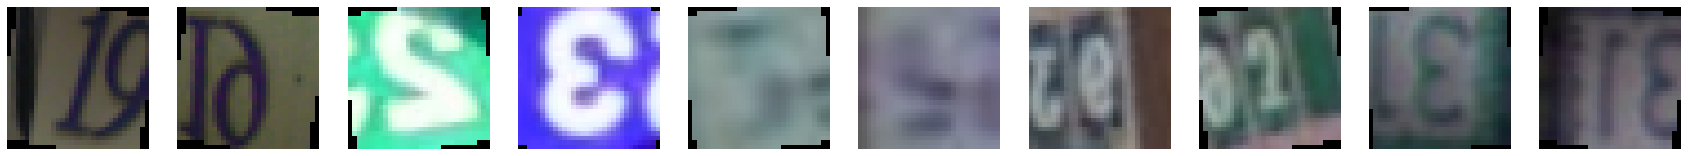

In [12]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN("/content/drive/My Drive/Colab Notebooks/", 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [15]:
# TODO: 
tfs = transforms.Compose([
   transforms.ColorJitter(hue=.50, saturation=.50),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                          
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN(root="/content/drive/My Drive/Colab Notebooks/", split='train', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 1, scheduler)

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [42]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=0),
            nn.BatchNorm2d(6, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120, affine=False),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84, affine=False),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=0.105978, weight_decay=0.000245)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=1)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 1, scheduler)

# Подбор гиперпараметров

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

# Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
# RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

# learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
# anneal_coeff = 0.2
# anneal_epochs = [1, 5, 10, 15, 20, 50]
# reg = [1e-3, 1e-4, 1e-5, 1e-7]

# batch_size = 64
# epoch_num = 10

# # Record all the runs here
# # Key should be Hyperparams and values should be RunResult
# run_record = {} 

# # Use grid search or random search and record all runs in run_record dictionnary 
# # Important: perform search in logarithmic space!

# # TODO: Your code here!


In [44]:
def approx_val_accur_reg_strength_learning_rate(trainer_func, train_loader, val_loader, \
                                            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor), num_epochs = 10, \
                                            num_experiments = 100, reg_strength_10_exp = (-6, 0), learning_rate_10_exp = (-6, 0)): 
    """
    ONLY FOR: Pytorch TENSORS, CUDA platform, optim.SGD  
    
    trainer_func - should return loss_history, train_accur_history, val_accur_history BY EPOCHS
    loss - for example nn.CrossEntropyLoss().type(torch.FloatTensor)
    nmb_experiments, int >= 100
    reg_strength_10_exp, tulip (-6, 0)   
    learning_rate_10_exp, tulip (-6, 0) 
    
    
    """
    loss_history = []  
    train_history = [] 
    val_history = [] 
    reg_strength_history = []
    learning_rate_history = []

    for count in range(num_experiments):
        print('Count #: %d'% (count+1))
        reg_strength = 10**np.random.uniform(reg_strength_10_exp[0],reg_strength_10_exp[1]) 
        learning_rate = 10**np.random.uniform(learning_rate_10_exp[0],learning_rate_10_exp[1])
        print('reg_strength: %f'% (reg_strength))
        print('learning_rate: %f'% (learning_rate))
        model = nn.Sequential(
                    nn.Conv2d(3, 6, 5, padding=0),
                    nn.BatchNorm2d(6, affine=False),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(6, 16, 5, padding=0),
                    nn.BatchNorm2d(16, affine=False),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    Flattener(),
                    nn.Linear(16*5*5, 120),
                    nn.BatchNorm1d(120, affine=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(120, 84),
                    nn.BatchNorm1d(84, affine=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(84, 10)
                  )

        model.type(torch.cuda.FloatTensor)
        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=1)
        loss_, train_, val_ = trainer_func(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler)
        loss_history.append(loss_[-1])
        train_history.append(train_[-1])
        val_history.append(val_[-1])
        reg_strength_history.append(reg_strength)
        learning_rate_history.append(learning_rate)
        
    approx_reg_strength = reg_strength_history[np.argmax(val_history)]
    approx_learning_rate = learning_rate_history[np.argmax(val_history)]
    approx_val_accur = np.max(val_history)
    print('best validation accuracy achieved: %f at reg_strength %f and learning_rate  %f' % (approx_val_accur, approx_reg_strength, approx_learning_rate))
    return approx_val_accur, approx_reg_strength, approx_learning_rate 


def final_val_accur_reg_strength_learning_rate(trainer_func, train_loader, val_loader, approx_reg_strength, approx_learning_rate, \
                                            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor), num_epochs = 10):    
    
    reg_strength_list =  np.array([0.8, 0.9, 1.0, 1.1, 1.2])*approx_reg_strength
    learning_rate_list = np.array([0.8, 0.9, 1.0, 1.1, 1.2])*approx_learning_rate

    loss_history = []
    train_history = []
    val_history = []
    reg_strength_history = []
    learning_rate_history = []

    for reg_strength in reg_strength_list:
        for learning_rate in learning_rate_list:
            print('reg_strength: %f'% (reg_strength))
            print('learning_rate: %f'% (learning_rate))
            model = nn.Sequential(
                    nn.Conv2d(3, 6, 5, padding=0),
                    nn.BatchNorm2d(6, affine=False),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(6, 16, 5, padding=0),
                    nn.BatchNorm2d(16, affine=False),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    Flattener(),
                    nn.Linear(16*5*5, 120),
                    nn.BatchNorm1d(120, affine=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(120, 84),
                    nn.BatchNorm1d(84, affine=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(84, 10)
                  )
            model.type(torch.cuda.FloatTensor)
            model.to(device)
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=1)
            loss_, train_, val_ = trainer_func(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler)
            loss_history.append(loss_[-1])
            train_history.append(train_[-1])
            val_history.append(val_[-1])
            reg_strength_history.append(reg_strength)
            learning_rate_history.append(learning_rate)
            
    final_reg_strength = reg_strength_history[np.argmax(val_history)]
    final_learning_rate = learning_rate_history[np.argmax(val_history)]
    final_val_accur = np.max(val_history)
    print('best validation accuracy achieved: %f at reg_strength %f and learning_rate  %f' % (final_val_accur, final_reg_strength, final_learning_rate))
    return final_val_accur, final_reg_strength, final_learning_rate 


def final_coef_gamma(trainer_func, train_loader, val_loader, reg_strength, learning_rate, \
                                            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor), \
                                            gamma_list = np.array([0.3, 0.6, 0.95]), num_epochs = 30):    
    
    loss_history = []
    train_history = []
    val_history = []

    for gamma in gamma_list:
        print('coef_gamma: %f'% (gamma))
        model = nn.Sequential(
                    nn.Conv2d(3, 6, 5, padding=0),
                    nn.BatchNorm2d(6, affine=False),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(6, 16, 5, padding=0),
                    nn.BatchNorm2d(16, affine=False),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2),
                    Flattener(),
                    nn.Linear(16*5*5, 120),
                    nn.BatchNorm1d(120, affine=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(120, 84),
                    nn.BatchNorm1d(84, affine=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(84, 10)
                  )
        model.type(torch.cuda.FloatTensor)
        model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
        loss_, train_, val_ = trainer_func(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler)
        loss_history.append(loss_[-1])
        train_history.append(train_[-1])
        val_history.append(val_[-1])
        
        val_accur_best = np.max(val_history)
        coef_gamma_best = gamma_list[np.argmax(val_history)] 
    print('best validation accuracy achieved: %f at coef_gamma %f' % (val_accur_best, coef_gamma_best)   )
    return val_accur_best, coef_gamma_best

In [45]:
approx_val_accur, approx_reg_strength, approx_learning_rate = approx_val_accur_reg_strength_learning_rate(train_model, train_aug_loader, val_loader, \
                                            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor), num_epochs = 1, \
                                            num_experiments = 1, reg_strength_10_exp = (-4, -3), learning_rate_10_exp = (-2, -1))

Count #: 1
reg_strength: 0.000736
learning_rate: 0.055124
Average loss: 0.800188, Train accuracy: 0.752568, Val accuracy: 0.852229
best validation accuracy achieved: 0.852229 at reg_strength 0.000736 and learning_rate  0.055124


In [ ]:
val_accur_best, reg_strength_best, learning_rate_best = final_val_accur_reg_strength_learning_rate(train_model, train_aug_loader, val_loader, approx_reg_strength, approx_learning_rate, \
                                            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor), num_epochs = 1)

In [49]:
val_accur_best, coef_gamma_best = final_coef_gamma(train_model, train_aug_loader, val_loader, reg_strength=approx_reg_strength, learning_rate=approx_learning_rate,  \
                                            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor), \
                                            gamma_list  = np.array([0.1]), num_epochs =1)

coef_gamma: 0.100000
Average loss: 0.813340, Train accuracy: 0.747944, Val accuracy: 0.856392
best validation accuracy achieved: 0.856392 at coef_gamma 0.100000


In [50]:
# Learn on all_data_aug_train
tfs = transforms.Compose([
   transforms.ColorJitter(hue=.50, saturation=.50),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(5, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4436, 0.4431, 0.4438],
                       std=[0.2035, 0.2036, 0.2037])                           
])

all_data_aug_train = dset.SVHN(root="/content/drive/My Drive/Colab Notebooks/", split='train', 
                       transform=tfs
                       )
all_train_aug_loader = torch.utils.data.DataLoader(all_data_aug_train, batch_size=batch_size, 
                                           sampler=None, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                         sampler=None)

lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=0),
            nn.BatchNorm2d(6, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(16*5*5, 120),
            nn.BatchNorm1d(120, affine=False),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84, affine=False),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=0.085467, weight_decay=0.000148)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=coef_gamma_best)
loss_history, train_history, val_history = train_model(lenet_model, all_train_aug_loader, test_loader, loss, optimizer, 1, scheduler)
# Val accuracy is test accuracy! 

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Average loss: 0.700106, Train accuracy: 0.782437, Val accuracy: 0.827174


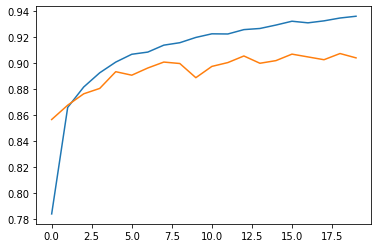

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

In [ ]:
# best_val_accuracy = None
# best_hyperparams = None
# best_run = None

# for hyperparams, run_result in run_record.items():
#     if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
#         best_val_accuracy = run_result.final_val_accuracy
#         best_hyperparams = hyperparams
#         best_run = run_result
        
# print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = None

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(lenet_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy) 

Test accuracy: 0.9039
